In [1]:
import pandas as pd
from pprint import pprint
import stan
from scipy.special import expit
from matplotlib import pyplot as plt
from numpy.random import normal, randint, binomial, choice
from numpy import percentile, concatenate, array, linspace, append
import numpy as np 
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import cohen_kappa_score
from sklearn.metrics import mean_squared_error,mean_absolute_error
from sklearn import metrics
import pickle
import nest_asyncio
from sklearn.metrics import roc_auc_score, accuracy_score, log_loss
import arviz as az
nest_asyncio.apply()

In [2]:
neededData = pd.read_csv('./data/neededData.csv')
print(neededData.shape)
neededData.head()

(809660, 6)


,user_id,item_id,timestamp,correct,nb_hint,answers_using_hint
535958,72,563,1125395408,0,0,4
562642,247,563,1125395410,1,0,2
569598,249,563,1125395414,1,0,2
555691,212,563,1125395416,1,0,2
545705,154,563,1125395419,0,0,4


In [3]:
needed = neededData[["user_id","item_id","correct"]]
needed.head()

,user_id,item_id,correct
535958,72,563,0
562642,247,563,1
569598,249,563,1
555691,212,563,1
545705,154,563,0


In [4]:
train_data = {'I': len(needed['item_id'].unique()),
              'S': len(needed['user_id'].unique()),
              'N': len(needed),
              'item': needed['item_id'].to_numpy(),
              'subject': needed['user_id'].to_numpy(),
              'grade': needed['correct'].to_numpy(),}
pprint(train_data)

{'I': 1084,
 'N': 809660,
 'S': 569,
 'grade': array([0, 1, 1, ..., 1, 1, 1]),
 'item': array([563, 563, 563, ..., 482, 482, 482]),
 'subject': array([ 72, 247, 249, ..., 392, 392, 392])}


In [5]:
# Load Model
with open("./data/_1pl_model_chains-2_numsamples-10000_numwarmup-1000_num_thin-1.pkl", "rb") as f:
    data_dict = pickle.load(f)
fit = data_dict['fit']
fit

<stan.Fit>
Parameters:
    ability: (569,)
    difficulty: (1084,)
    delta: ()
Draws: 20000

In [7]:
fit.to_frame()

parameters,lp__,accept_stat__,stepsize__,treedepth__,n_leapfrog__,divergent__,energy__,ability.1,ability.2,ability.3,...,difficulty.1076,difficulty.1077,difficulty.1078,difficulty.1079,difficulty.1080,difficulty.1081,difficulty.1082,difficulty.1083,difficulty.1084,delta
draws,,,,,,,,,,,,,,,,,,,,,
0,-416458.979744,0.993157,0.059306,6.0,63.0,0.0,417306.268372,0.072418,-0.094755,0.155953,...,0.469498,-0.001994,0.268988,0.102701,0.185740,0.304074,0.080438,-0.015730,-0.639097,1.270689
1,-416442.556419,0.929517,0.073529,6.0,63.0,0.0,417221.586961,-0.005675,-0.380859,-0.171999,...,0.302296,0.020200,0.106020,0.179567,-0.040328,0.132394,0.048308,-0.477554,-0.633418,1.296450
2,-416440.094872,0.673219,0.059306,6.0,63.0,0.0,417262.584386,0.042418,-0.246988,-0.079835,...,0.416312,0.215892,0.223295,0.064367,-0.012916,0.115174,0.121240,-0.251281,-0.558338,1.272121
3,-416446.984408,0.996265,0.073529,6.0,63.0,0.0,417249.833005,0.010935,-0.408111,-0.247672,...,0.307763,0.030223,0.138482,0.274823,0.041838,0.062035,0.070890,-0.386612,-0.638208,1.293057
4,-416437.325196,0.893959,0.059306,6.0,63.0,0.0,417314.465261,0.082405,-0.087142,0.144979,...,0.489710,-0.175824,0.229013,0.222765,0.247518,0.229145,-0.050597,-0.011173,-0.528149,1.286551
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19995,-416455.144226,0.987815,0.073529,6.0,63.0,0.0,417281.134069,0.003045,-0.230419,0.050654,...,0.524667,0.124137,0.218917,-0.016251,0.060007,0.211008,-0.196372,-0.350911,-0.542764,1.341105
19996,-416445.816154,0.798005,0.059306,6.0,63.0,0.0,417276.077075,0.077918,-0.444486,0.032028,...,0.514142,-0.009589,0.251271,-0.010979,0.097686,0.079647,-0.004556,-0.252331,-0.563220,1.275386
19997,-416453.774196,0.977165,0.073529,6.0,63.0,0.0,417299.331025,0.004659,-0.218324,-0.068875,...,0.363220,-0.048193,0.208887,0.235503,0.170438,0.143657,0.230764,0.030247,-0.573386,1.333173


In [27]:
ability = np.mean(fit['ability'],axis=1)
difficulty = np.mean(fit['difficulty'],axis=1)
#discrimination = np.mean(binary_fit['discrimination'],axis=1)

In [29]:
ability = np.mean(fit['ability'],axis=1)
difficulty = np.mean(fit['difficulty'],axis=1)
y_pred = []
for i in range(0,len(needed)):
    diff = train_data['item'][i] # Item index
    abilt = train_data['subject'][i] # Subject index
    p = np.exp(ability[abilt - 1 ] - difficulty[diff - 1])/(1+np.exp(ability[abilt - 1] - difficulty[diff - 1]))
    y_pred.append(p)
y_pred = np.round(y_pred).astype(int) # convertir la probabilité de reussite a un item.
y_pred

IndexError: index 71 is out of bounds for axis 0 with size 15

In [14]:
print(f" mse = {mean_squared_error(train_data['grade'],y_pred)} \n kappa = {cohen_kappa_score(train_data['grade'],y_pred)} \n auc = {roc_auc_score(train_data['grade'],y_pred)} \n acc = {accuracy_score(train_data['grade'],y_pred)}   ")

 mse = 0.42118914112096434 
 kappa = 0.15877255234989252 
 auc = 0.6110461386380821 
 acc = 0.5788108588790356   


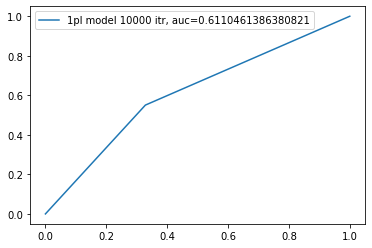

In [21]:
plt.figure(0).clf()

fpr, tpr, thresh = metrics.roc_curve(train_data['grade'],y_pred)
auc = metrics.roc_auc_score(train_data['grade'],y_pred)
plt.plot(fpr,tpr,label="1pl model 10000 itr, auc="+str(auc))

# pred = np.random.rand(1000)
# label = np.random.randint(2, size=1000)
# fpr, tpr, thresh = metrics.roc_curve(label, pred)
# auc = metrics.roc_auc_score(label, pred)
# plt.plot(fpr,tpr,label="data 2, auc="+str(auc))

plt.legend(loc=0)

In [28]:
ability = np.mean(fit['ability'],axis=1)
difficulty = np.mean(fit['difficulty'],axis=1)

Text(0.5, 1.0, 'The logistic function')

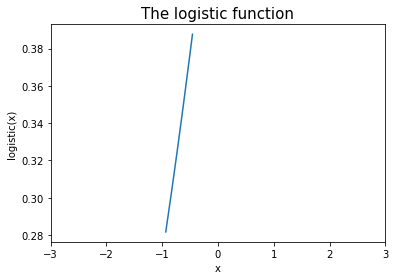

In [33]:
x_axis = fit['ability'][568]
x_axis.sort()
plt.plot(x_axis, expit(x_axis))
plt.xlabel('x')
plt.xlim([-3, 3])
plt.ylabel('logistic(x)')
plt.title('The logistic function', fontsize=15)

Text(0.5, 1.0, 'The logistic function')

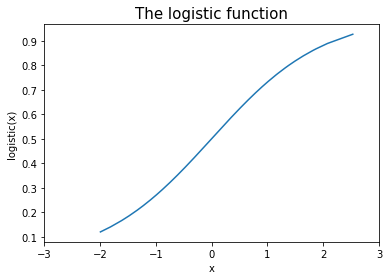

In [25]:
x_axis = difficulty
x_axis.sort()
plt.plot(x_axis, expit(x_axis))
plt.xlabel('x')
plt.xlim([-3, 3])
plt.ylabel('logistic(x)')
plt.title('The logistic function', fontsize=15)

In [15]:
abilities = fit['ability']
len(abilities)

569

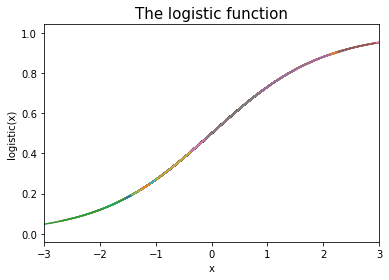

In [22]:
abilities = fit['ability']
for i in range(0,569):
    x_axis = abilities[i]
    x_axis.sort()
    plt.plot(x_axis, expit(x_axis))
    plt.xlabel('x')
    plt.xlim([-3, 3])
    plt.ylabel('logistic(x)')
    plt.title('The logistic function', fontsize=15)

Text(0.5, 1.0, 'The logistic function')

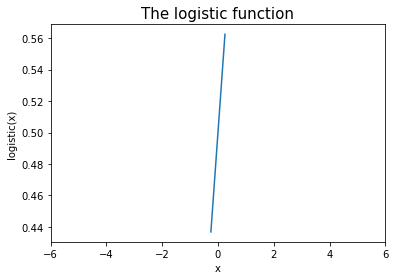

In [23]:
difficulties = fit['difficulty']
x_axis = difficulties[21]
x_axis.sort()
plt.plot(x_axis, expit(x_axis))
plt.xlabel('x')
plt.xlim([-6, 6])
plt.ylabel('logistic(x)')
plt.title('The logistic function', fontsize=15)

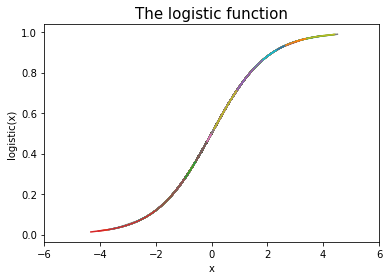

In [16]:
difficulties = fit['difficulty']
for i in range(0,569):
    x_axis = difficulties[i]
    x_axis.sort()
    plt.plot(x_axis, expit(x_axis))
    plt.xlabel('x')
    plt.xlim([-6, 6])
    plt.ylabel('logistic(x)')
    plt.title('The logistic function', fontsize=15)

/home/abarchi/miniconda3/lib/python3.8/site-packages/arviz/plots/plot_utils.py:490: UserWarning: rcParams['plot.max_subplots'] (40) is smaller than the number of variables to plot (569) in plot_posterior, generating only 40 plots
  warnings.warn(


Text(0, 0.5, 'Relative density')

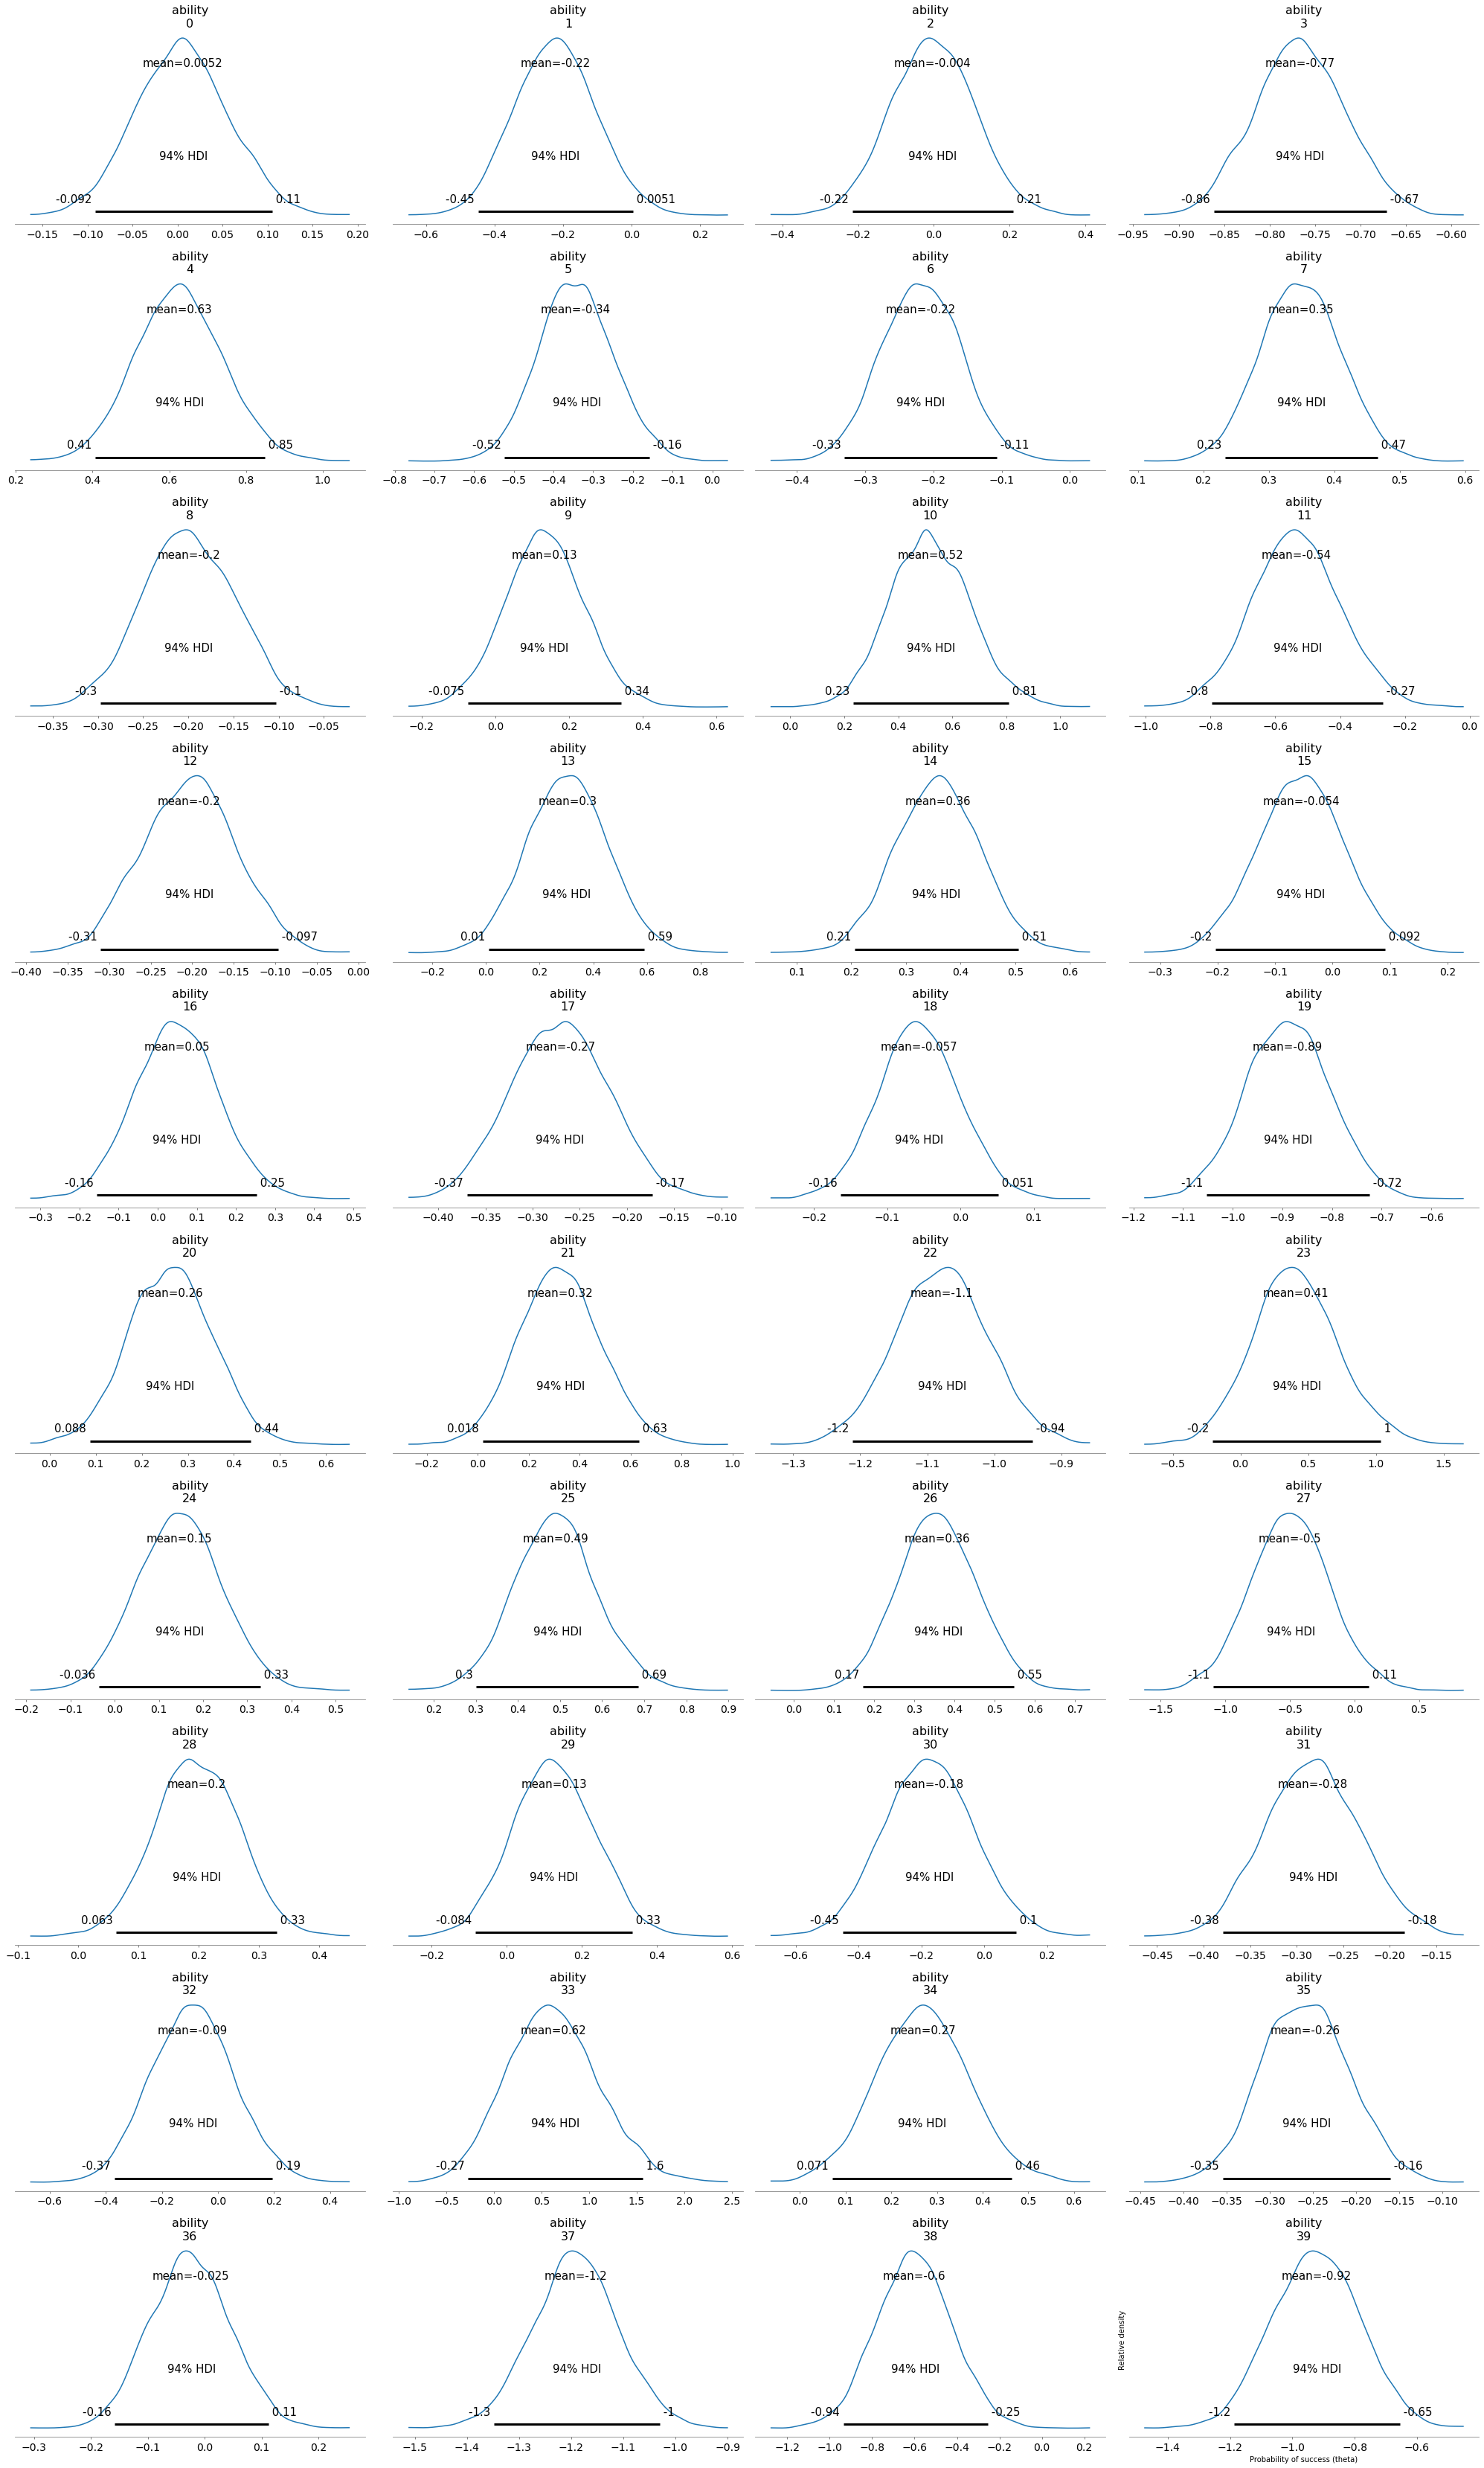

In [26]:
az.plot_posterior(fit,var_names=['ability'],multimodal=True)
plt.xlabel(r'Probability of success (theta)')
plt.ylabel('Relative density')

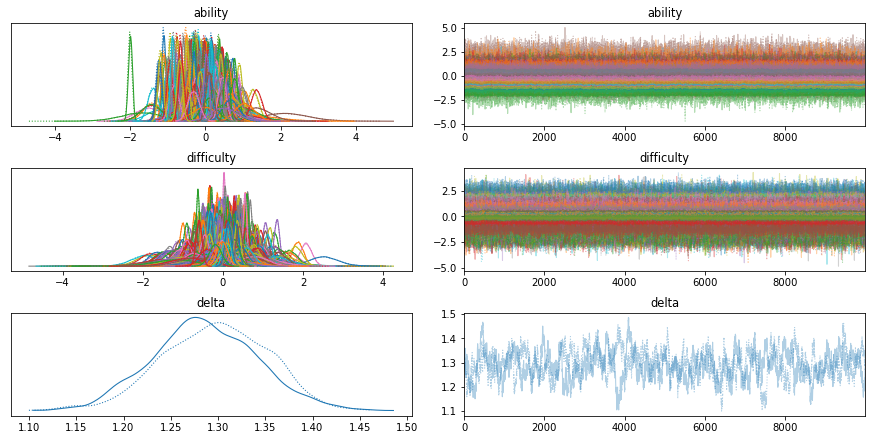

In [8]:
axes = az.plot_trace(fit)
fig = axes.ravel()[0].figure
fig.savefig("model_plot-trace.png")

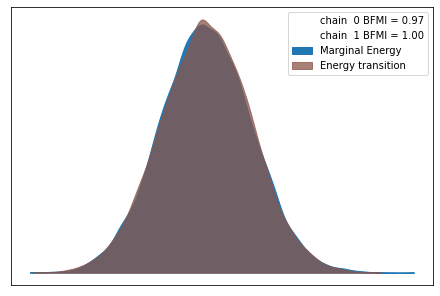

In [6]:
inf_data = az.convert_to_inference_data(fit)
axes = az.plot_energy(inf_data)
fig = axes.figure
fig.savefig("model_energy.png")

In [9]:
az.bfmi(inf_data)

array([0.97172501, 0.99978999])

In [20]:
%%capture Jupyter notebook
rhat = az.rhat(inf_data)
print(rhat)

UsageError: unrecognized arguments: notebook


In [11]:
az.mcse(inf_data)

<xarray.Dataset>
Dimensions:           (ability_dim_0: 569, difficulty_dim_0: 1084)
Coordinates:
  * ability_dim_0     (ability_dim_0) int64 0 1 2 3 4 5 ... 564 565 566 567 568
  * difficulty_dim_0  (difficulty_dim_0) int64 0 1 2 3 4 ... 1080 1081 1082 1083
Data variables:
    ability           (ability_dim_0) float64 0.003377 0.003362 ... 0.003382
    difficulty        (difficulty_dim_0) float64 0.002125 0.002069 ... 0.002143
    delta             float64 0.004165

In [12]:
az.ess(inf_data)

<xarray.Dataset>
Dimensions:           (ability_dim_0: 569, difficulty_dim_0: 1084)
Coordinates:
  * ability_dim_0     (ability_dim_0) int64 0 1 2 3 4 5 ... 564 565 566 567 568
  * difficulty_dim_0  (difficulty_dim_0) int64 0 1 2 3 4 ... 1080 1081 1082 1083
Data variables:
    ability           (ability_dim_0) float64 256.1 1.284e+03 ... 465.6
    difficulty        (difficulty_dim_0) float64 1.306e+03 ... 1.164e+03
    delta             float64 186.4

In [18]:
az.ks_summary(inf_data)

AttributeError: module 'arviz' has no attribute 'ks_summary'

In [26]:
inf_data.sample_stats

<xarray.Dataset>
Dimensions:      (chain: 2, draw: 10000)
Coordinates:
  * chain        (chain) int64 0 1
  * draw         (draw) int64 0 1 2 3 4 5 6 ... 9994 9995 9996 9997 9998 9999
Data variables:
    accept_stat  (chain, draw) float64 0.9932 0.6732 0.894 ... 0.9772 0.8793
    stepsize     (chain, draw) float64 0.05931 0.05931 ... 0.07353 0.07353
    treedepth    (chain, draw) int64 6 6 6 6 6 6 6 6 6 6 ... 6 6 6 6 6 6 6 6 6 6
    n_leapfrog   (chain, draw) int64 63 63 63 63 63 63 63 ... 63 63 63 63 63 63
    diverging    (chain, draw) bool False False False ... False False False
    energy       (chain, draw) float64 4.173e+05 4.173e+05 ... 4.172e+05
    lp           (chain, draw) float64 -4.165e+05 -4.164e+05 ... -4.164e+05
Attributes:
    created_at:                 2021-07-15T15:26:45.291958
    arviz_version:              0.11.2
    inference_library:          stan
    inference_library_version:  3.2.0
    num_chains:                 2
    num_samples:                10000
    num_thin:                   1
    num_warmup:                 1000
    save_warmup:                0

In [27]:
inf_data.posterior

<xarray.Dataset>
Dimensions:           (ability_dim_0: 569, chain: 2, difficulty_dim_0: 1084, draw: 10000)
Coordinates:
  * chain             (chain) int64 0 1
  * draw              (draw) int64 0 1 2 3 4 5 ... 9994 9995 9996 9997 9998 9999
  * ability_dim_0     (ability_dim_0) int64 0 1 2 3 4 5 ... 564 565 566 567 568
  * difficulty_dim_0  (difficulty_dim_0) int64 0 1 2 3 4 ... 1080 1081 1082 1083
Data variables:
    ability           (chain, draw, ability_dim_0) float64 0.07242 ... -0.7917
    difficulty        (chain, draw, difficulty_dim_0) float64 -0.4367 ... -0....
    delta             (chain, draw) float64 1.271 1.272 1.287 ... 1.333 1.332
Attributes:
    created_at:                 2021-07-15T15:26:45.255559
    arviz_version:              0.11.2
    inference_library:          stan
    inference_library_version:  3.2.0
    num_chains:                 2
    num_samples:                10000
    num_thin:                   1
    num_warmup:                 1000
    save_warmup:                0

In [31]:
inf_data.prior

AttributeError: 'InferenceData' object has no attribute 'prior'

In [22]:
az.pair_plot(fit,divergences=True)

AttributeError: module 'arviz' has no attribute 'pair_plot'

In [23]:
az.report_trace(fit)

AttributeError: module 'arviz' has no attribute 'report_trace'

# Trace plot exemple

In [9]:
def plot_trace(param, param_name='parameter'):
  """Plot the trace and posterior of a parameter."""
  
  # Summary statistics
  mean = np.mean(param)
  median = np.median(param)
  cred_min, cred_max = np.percentile(param, 2.5), np.percentile(param, 97.5)
  
  # Plotting
  plt.subplot(2,1,1)
  plt.plot(param)
  plt.xlabel('samples')
  plt.ylabel(param_name)
  plt.axhline(mean, color='r', lw=2, linestyle='--')
  plt.axhline(median, color='c', lw=2, linestyle='--')
  plt.axhline(cred_min, linestyle=':', color='k', alpha=0.2)
  plt.axhline(cred_max, linestyle=':', color='k', alpha=0.2)
  plt.title('Trace and Posterior Distribution for {}'.format(param_name))

  plt.subplot(2,1,2)
  plt.hist(param, 30, density=True); sns.kdeplot(param, shade=True)
  plt.xlabel(param_name)
  plt.ylabel('density')
  plt.axvline(mean, color='r', lw=2, linestyle='--',label='mean')
  plt.axvline(median, color='c', lw=2, linestyle='--',label='median')
  plt.axvline(cred_min, linestyle=':', color='k', alpha=0.2, label='95% CI')
  plt.axvline(cred_max, linestyle=':', color='k', alpha=0.2)
  
  plt.gcf().tight_layout()
  plt.legend()

In [10]:
abty = fit['ability']

In [ ]:
plot_trace(abty)

ValueError: If using all scalar values, you must pass an index